# Unified Data Exploratory Data Analysis (EDA)

This notebook analyzes data from three sources:
1.  **Google Trends**: Trending keywords and their search volumes.
2.  **News Articles**: Coverage of trends from major Vietnamese news outlets (VnExpress, Tuoi Tre, etc.).
3.  **Facebook Posts**: Social media engagement and discussions related to these trends.

## 1. Google Trends Analysis

Loading Google Trends from: ../crawlers/trending_VN_7d_20251208-1452.csv


/tmp/ipykernel_6030/2167444644.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='SearchVolume', y='Xu hướng', palette='viridis')


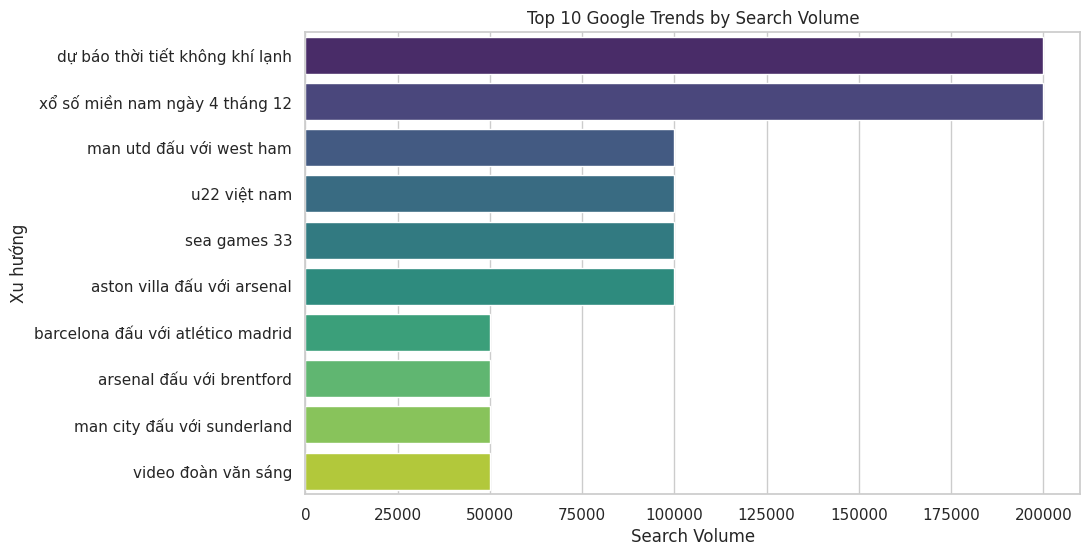

In [1]:
import pandas as pd
import glob
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Setup plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Google Trends Data
trend_files = glob.glob('../crawlers/trending_VN_*.csv')
if not trend_files:
    print("No trending files found!")
else:
    latest_trend_file = max(trend_files, key=os.path.getctime)
    print(f"Loading Google Trends from: {latest_trend_file}")
    
    # Note: The CSV structure has a header on line 1 (0-indexed) or just starts with specific cols
    # Based on inspection, column 0 is 'Xu hướng', column 1 is 'Lượng tìm kiếm'
    trends_df = pd.read_csv(latest_trend_file)
    
    # Basic cleaning
    trends_df['Lượng tìm kiếm'] = trends_df['Lượng tìm kiếm'].astype(str).str.replace('+', '').str.replace(',', '').str.replace('.', '')
    
    def parse_volume(vol):
        if 'N' in vol:
            return int(vol.replace('N', '').strip()) * 1000
        if 'Tr' in vol:
            return int(vol.replace('Tr', '').strip()) * 1000000
        try:
            return int(vol)
        except:
            return 0
            
    if 'Lượng tìm kiếm' in trends_df.columns:
        trends_df['SearchVolume'] = trends_df['Lượng tìm kiếm'].apply(parse_volume)
        
        # Top 10 Trends
        top_10 = trends_df.sort_values('SearchVolume', ascending=False).head(10)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=top_10, x='SearchVolume', y='Xu hướng', palette='viridis')
        plt.title('Top 10 Google Trends by Search Volume')
        plt.xlabel('Search Volume')
        plt.show()
    else:
        print("Could not find 'Lượng tìm kiếm' column. Columns:", trends_df.columns)

## 2. News Coverage Analysis

/tmp/ipykernel_6030/3995336121.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=news_df, x='source', palette='pastel')


Total Articles Loaded: 1413


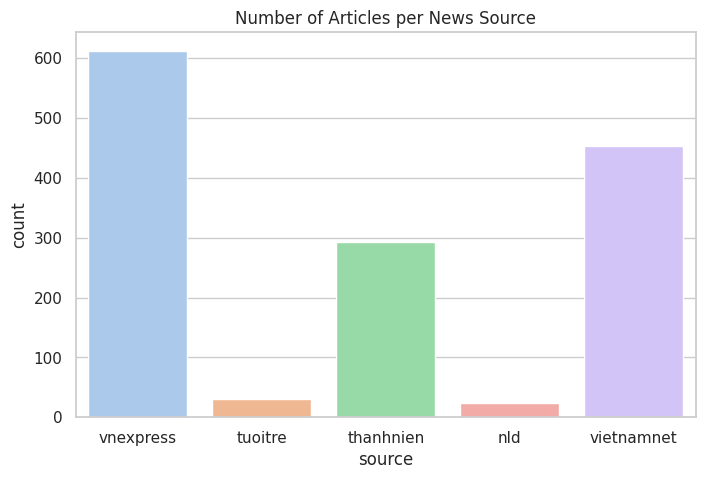

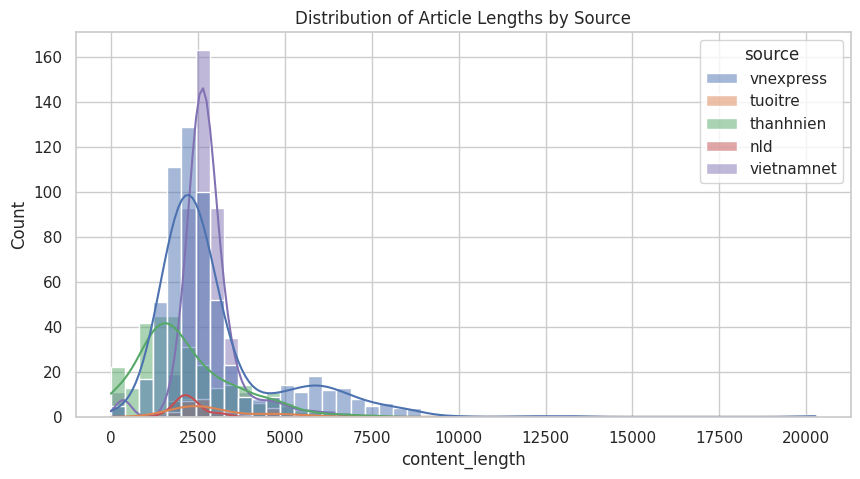

In [2]:
news_dir = '../data'
news_outlets = ['vnexpress', 'tuoitre', 'thanhnien', 'nld', 'vietnamnet']
all_articles = []

for outlet in news_outlets:
    csv_path = os.path.join(news_dir, outlet, 'articles.csv')
    if os.path.exists(csv_path):
        try:
            df = pd.read_csv(csv_path)
            df['source'] = outlet
            all_articles.append(df)
        except Exception as e:
            print(f"Error loading {outlet}: {e}")

if all_articles:
    news_df = pd.concat(all_articles, ignore_index=True)
    print(f"Total Articles Loaded: {len(news_df)}")
    
    # Articles per Source
    plt.figure(figsize=(8, 5))
    sns.countplot(data=news_df, x='source', palette='pastel')
    plt.title('Number of Articles per News Source')
    plt.show()
    
    # Content Length Distribution
    news_df['content_length'] = news_df['content'].fillna('').str.len()
    plt.figure(figsize=(10, 5))
    sns.histplot(data=news_df, x='content_length', bins=50, kde=True, hue='source')
    plt.title('Distribution of Article Lengths by Source')
    plt.show()
    
else:
    print("No news articles found.")

## 3. Facebook Data Analysis

Loading Facebook data from: ../crawlers/facebook/fb_data.json
Total Facebook Posts: 1190
Engagement Statistics:
               likes      comments       shares
count    1190.000000   1190.000000  1190.000000
mean     3565.124370    138.700840    79.484034
std     10492.155092    544.495317   323.275659
min         0.000000      0.000000     0.000000
25%        26.250000      0.000000     1.000000
50%       202.000000      3.000000     6.000000
75%      3300.000000     54.750000    39.000000
max    166000.000000  10000.000000  9000.000000


/tmp/ipykernel_6030/3424189810.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(tags), palette='rocket')


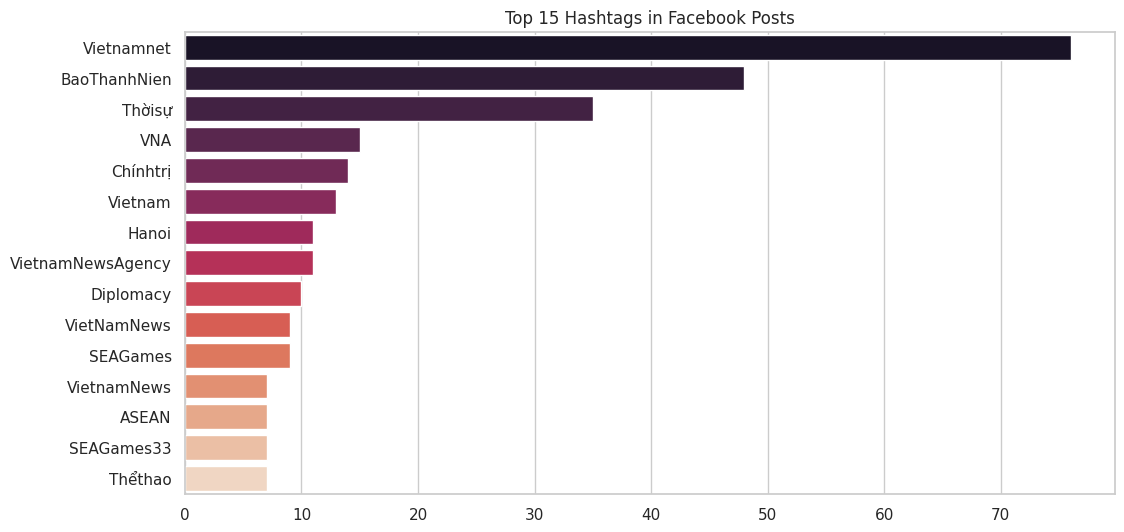

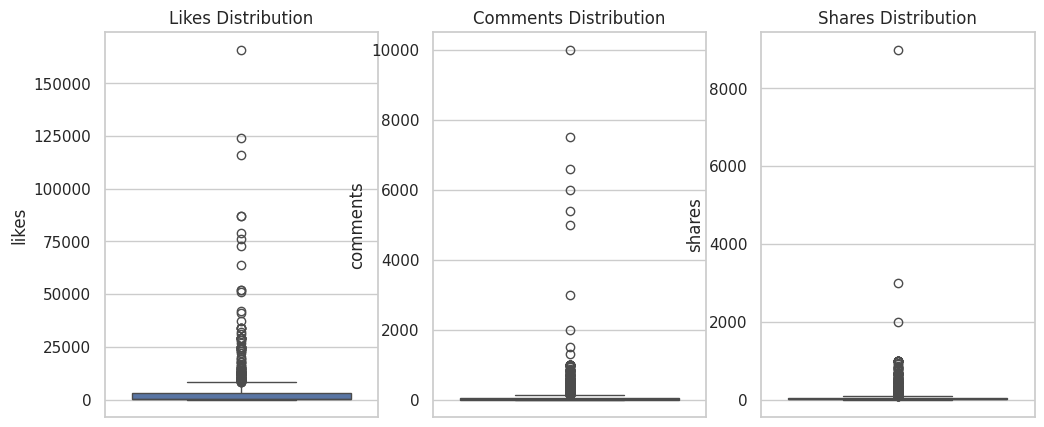

In [3]:
fb_file = '../crawlers/facebook/fb_data.json'

if os.path.exists(fb_file):
    print(f"Loading Facebook data from: {fb_file}")
    with open(fb_file, 'r', encoding='utf-8') as f:
        fb_data = json.load(f)
    
    fb_df = pd.DataFrame(fb_data)
    print(f"Total Facebook Posts: {len(fb_df)}")

    # Parse 'stats' column which contains dictionary of metrics
    def get_stat(stats_dict, key):
        if isinstance(stats_dict, dict):
            val = stats_dict.get(key, 0)
            # Handle potential string formatting if any
            if isinstance(val, str):
                return pd.to_numeric(str(val).replace('K', '000').replace('.', ''), errors='coerce')
            return val
        return 0
    
    # Convert engagement metrics to numeric
    numeric_cols = ['likes', 'comments', 'shares']
    for col in numeric_cols:
        fb_df[col] = fb_df['stats'].apply(lambda x: get_stat(x, col)).fillna(0)
        
    # Engagement Metrics
    print("Engagement Statistics:")
    print(fb_df[numeric_cols].describe())
    
    from collections import Counter
    import re
    
    # Top Hashtags
    all_hashtags = []
    for text in fb_df['content'].dropna():
        hashtags = re.findall(r'#(\w+)', text)
        all_hashtags.extend(hashtags)
        
    top_hashtags = Counter(all_hashtags).most_common(15)
    if top_hashtags:
        tags, counts = zip(*top_hashtags)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=list(counts), y=list(tags), palette='rocket')
        plt.title('Top 15 Hashtags in Facebook Posts')
        plt.show()
        
    # Engagement Distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    sns.boxplot(y=fb_df['likes'])
    plt.title('Likes Distribution')
    
    plt.subplot(1, 3, 2)
    sns.boxplot(y=fb_df['comments'])
    plt.title('Comments Distribution')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(y=fb_df['shares'])
    plt.title('Shares Distribution')
    plt.show()
    
else:
    print("Facebook data file not found.")